### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

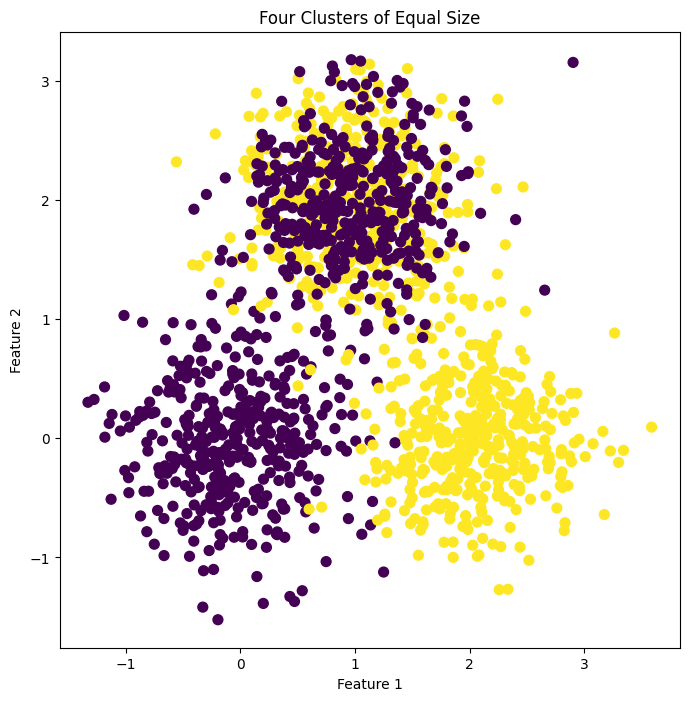

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [8]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data2")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 59.81it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 58.29it/s, v_num=17]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v16.ckpt



Best model from Phase 1 saved to: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v16.ckpt

--- Testing model from Phase 1 checkpoint: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v16.ckpt ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.6139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 108.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873144507408142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on 

### Undersampling ROC curve

In [10]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---

# 1. Get original class counts from your train_dataset

try:
    original_labels = np.array(train_data.targets).flatten()
except AttributeError:
    original_labels = train_data[:, -1]

original_counts = Counter(original_labels)
num_pos_original = original_counts.get(1, 0)  
num_neg_original = original_counts.get(0, 0)  
print(f"Original class counts: {num_pos_original} positives, {num_neg_original} negatives")

# The pivot point for your function's logic
orig_sample_ratio = num_pos_original / num_neg_original 

# 2. Define how many steps for each regime
N_POINTS_PER_REGIME = 25  # You can change this

# 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
# This will test scenarios from extreme negative-class dominance up to the original balance.
print(f"Generating ratios for Regime 1 (target ratio < {orig_sample_ratio})...")
ratios_regime1 = np.geomspace(
    start=1/num_neg_original,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
    stop=orig_sample_ratio,         # Go up to the original ratio
    num=N_POINTS_PER_REGIME,
    endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
)

# 4. Generate ratios for Regime 2 (from the pivot up to 3494)
# This will test scenarios from the original balance up to extreme positive-class dominance.
print(f"Generating ratios for Regime 2 (target ratio > {orig_sample_ratio})...")
ratios_regime2 = np.geomspace(
    start=orig_sample_ratio, # Start just above the pivot
    stop=num_pos_original,                      # Your specified upper limit
    num=N_POINTS_PER_REGIME
)

# 5. Combine, sort, and create the final list for the loop
#    We also add the original ratio to ensure we have a baseline run.
all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
print("First few ratios:", np.round(all_ratios[:5], 3))
print("Last few ratios:", np.round(all_ratios[-5:], 2))

Original class counts: 500 positives, 500 negatives
Generating ratios for Regime 1 (target ratio < 1.0)...
Generating ratios for Regime 2 (target ratio > 1.0)...

Generated 51 unique sample ratios to test.
First few ratios: [0.002 0.003 0.003 0.004 0.005]
Last few ratios: [177.48 229.93 297.89 385.93 500.  ]


In [11]:
import numpy as np
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    try:
        labels = np.array(train_dataset.targets).flatten()
    except AttributeError:
        labels = train_dataset[:, -1]

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # Create a subset of the original dataset with the sampled indices
    return train_dataset[final_indices]

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, sample_ratio in enumerate(all_ratios):
        # 1. Instantiate the LightningModule
        model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{sample_ratio}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=test_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Fold 1/4 ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.49it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.20it/s, v_num=4]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 62.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5324
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 59.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6935874819755554
─────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.31it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.00it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 479.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3367
AUC: 0.2818
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7320709228515625
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.46it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.58it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.7972
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6611687541007996
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.81it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 498.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3167
AUC: 0.3323
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7174733281135559
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.55it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.80it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.5724
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6855311393737793
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.69it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.36it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.7260
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6187953948974609
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.87it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.29it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.5952
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6909157633781433
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.09it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.41it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3067
AUC: 0.3249
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7324007749557495
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.27it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.87it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.5862
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6876469254493713
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.66it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.17it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7736
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6980063915252686
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.46it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.95it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6709
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6802952885627747
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.98it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.91it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v15.ckpt



--- Fold 1 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v15.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v15.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3878
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004754543304443
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.74it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.49it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.8132
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6642037034034729
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.80it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.34it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4383
AUC: 0.3926
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167729139328003
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.90it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.80it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6272
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7211912274360657
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.58it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.31it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.5418
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921325922012329
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.12it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.51it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8495
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667738556861877
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.56it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.53it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.4083
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7023031115531921
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.68it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.44it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.4576
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7265557646751404
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.40it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.90it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3767
AUC: 0.3933
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004746198654175
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.41it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.35it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.7344
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6686084270477295
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.53it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.91it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 453.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.6207
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6672404408454895
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.42it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.01it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.8360
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6192159056663513
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.95it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5349
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6975312232971191
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.50it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.46it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 480.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.4323
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7186456918716431
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.97it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.11it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.8321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.645618200302124
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.33it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.53it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2897
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7433796525001526
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.00it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.22it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.6501
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683708429336548
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.54it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.70it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.6144
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6606033444404602
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.49it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.03it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6678
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822472810745239
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.30it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.07it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6333
AUC: 0.6420
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6643736362457275
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.51it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.27it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6479015350341797
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.64it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.96it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5257
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203903198242188
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.90it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.41it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6100
AUC: 0.5892
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6786776781082153
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.72it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.63it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.6442
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6775423288345337
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.71it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.03it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4235
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7645981907844543
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.48it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.34it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.8083
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6592474579811096
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.88it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.13it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3133
AUC: 0.2626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7227150797843933
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.05it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 46.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 45.70it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7120358347892761
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.95it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.20it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 466.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6533
AUC: 0.5810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6756995320320129
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.85it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.87it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.3654
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468218803405762
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.19it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.60it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.6225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6583920121192932
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.91it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.37it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931405663490295
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.77it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.25it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.7583
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6735368967056274
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.40it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.50it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5867
AUC: 0.6283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6633777618408203
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.75it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.88it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.6979
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6532946825027466
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.43it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.93it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.6116
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6621900200843811
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6839
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6755555272102356
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.08it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.57it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 498.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7640
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676030158996582
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.58it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.22it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 525.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4732
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7036524415016174
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.10it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.18it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.7480
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6558300852775574
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 2/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.97it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.35it/s, v_num=4]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v14.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.5292
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6934187412261963
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.52it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.04it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3183
AUC: 0.2810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7998035550117493
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.81it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.74it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.1618
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7408906817436218
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.36it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.87it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3868
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7340397238731384
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.04it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.64it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 484.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.3725
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7200642824172974
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.17it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 487.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4244
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6997610330581665
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.77it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.72it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2726
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 222.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7240930795669556
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.91it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.82it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2850
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7092828750610352
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.77it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3417
AUC: 0.2803
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7242739200592041
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.64it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5550
AUC: 0.6044
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7126674652099609
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.88it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.07it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4100
AUC: 0.4339
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7195765972137451
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.50it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.61it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.4160
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7154594659805298
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.61it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.06it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4667
AUC: 0.4105
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7171159386634827
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.29it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.85it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 452.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.4512
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7060206532478333
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.35it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.43it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6733
AUC: 0.7829
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6569096446037292
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.73it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.05it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.8033
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6823813915252686
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.39it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.7191
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6875280737876892
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.21it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.91it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.6647
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899111270904541
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.45it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.13it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.3329
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7142128348350525
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.50it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.7729
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6631092429161072
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.33it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.28it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2320
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7696658372879028
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.76it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.18it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7033
AUC: 0.7603
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6524736285209656
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.11it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.20it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.5620
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871575117111206
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.90it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.84it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 490.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.5391
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7008068561553955
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.86it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.88it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.4607
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7358635663986206
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.97it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.04it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.6789
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6418201327323914
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.57it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.6682
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761319637298584
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.14it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.68it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6675
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6588087677955627
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.15it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.1686
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7545815110206604
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.94it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.61it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4889
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003297805786133
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.38it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.36it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7302
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6679884791374207
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.66it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.28it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6950
AUC: 0.6342
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6688566207885742
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.79it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.69it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.7722
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.678982675075531
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.02it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.03it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 453.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.6287
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665812611579895
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.45it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.35it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.5867
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871759295463562
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.83it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.70it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.7465
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676682710647583
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.33it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.05it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6683
AUC: 0.8420
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6563915014266968
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.83it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.71it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 448.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6050
AUC: 0.7477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6677433252334595
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.93it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.98it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 535.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3450
AUC: 0.3972
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7141336798667908
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.08it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.42it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 465.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.4570
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7030401825904846
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.86it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.25it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 488.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.5405
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.724970281124115
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.17it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.00it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3275
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212554216384888
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.29it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.69it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.7928
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6649766564369202
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.62it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.7450
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6811764240264893
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.67it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.27it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4633
AUC: 0.3261
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7080324292182922
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.33it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.26it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.8019
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 263.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.615726113319397
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.25it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.84it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7176
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6714149713516235
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.87it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.67it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 510.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.4828
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7079570889472961
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.53it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.51it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6914
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6782016158103943
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.40it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.51it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v14.ckpt



--- Fold 2 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6853
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6965907216072083
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.65it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.25it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.5656
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6835852265357971
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.20it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.61it/s, v_num=4]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v14.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 471.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.6680
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6674631834030151
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.93it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.34it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4650
AUC: 0.3304
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7220334410667419
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.51it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.6465
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6783530712127686
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.75it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.67it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.8408
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6540181040763855
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.86it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.46it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.6748
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6698498725891113
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.60it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.00it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4500
AUC: 0.2358
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7999160885810852
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.14it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.99it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.7781
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 210.45it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6644425392150879
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.31it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.40it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.4838
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6967868804931641
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.69it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.32it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 516.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7233
AUC: 0.8306
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6286381483078003
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.58it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.07it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6500
AUC: 0.6363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6531161665916443
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.69it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.28it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 480.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.2649
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468863725662231
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.84it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.47it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7517
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6501479744911194
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.85it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.21it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4650
AUC: 0.2444
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7393770217895508
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.22it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.53it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.7373
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6528001427650452
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.26it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.95it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.8155
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6421154141426086
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.15it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.18it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7300
AUC: 0.6783
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6334452033042908
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.60it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.62it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6743
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6943482756614685
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.42it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.94it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6033
AUC: 0.8239
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.652576208114624
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.60it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.09it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.7718
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6258061528205872
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.76it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.86it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4617
AUC: 0.4150
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7226155996322632
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.85it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.51it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6957902312278748
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.77it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.73it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.7968
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6397635340690613
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.65it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.81it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 454.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6762
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6889066696166992
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.03it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6738
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6653105020523071
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.35it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.35it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7797
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6769136190414429
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.47it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.88it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6467
AUC: 0.7744
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6404605507850647
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.81it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.16it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6467
AUC: 0.6345
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764524579048157
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.27it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.28it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.4924
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106986045837402
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.89it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.71it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4150
AUC: 0.4222
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7514390349388123
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.59it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.17it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4908
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7073315382003784
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.85it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.84it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.2526
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7257824540138245
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.12it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.89it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6500
AUC: 0.7257
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6762970685958862
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.07it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.08it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6916595697402954
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.50it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.78it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.8348
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6700393557548523
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.32it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.48it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.7966
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6562856435775757
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.77it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.33it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3850
AUC: 0.4263
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7285356521606445
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.13it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.14it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3700
AUC: 0.3893
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7011798024177551
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.97it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.83it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 474.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.7780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.658084511756897
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.79it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.85it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.6160
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.42it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6778323650360107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.69it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.15it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2933
AUC: 0.3694
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7564748525619507
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.81it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.72it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5046
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.745718777179718
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.31it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.07it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.8107
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 244.53it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6425721049308777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.89it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.62it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.4148
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 273.40it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7208626866340637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.92it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.21it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.2502
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 263.32it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7618725299835205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.48it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.79it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 213.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6941
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 166.00it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6796151995658875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.69it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5600
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6890968680381775
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.07it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.17it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6783
AUC: 0.7290
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6636635661125183
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.20it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.93it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4483
AUC: 0.4395
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7338537573814392
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.88it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.87it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.8524
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6542264819145203
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.23it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.09it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v14.ckpt



--- Fold 3 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3633
AUC: 0.2333
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7433945536613464
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.88it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.21it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3117
AUC: 0.3123
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7291764616966248
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 4/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.32it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.20it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5797
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6877461075782776
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.87it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6750
AUC: 0.8376
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6282990574836731
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.83it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.6532
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.69it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6690914630889893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.62it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.97it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5983
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752570867538452
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.10it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.15it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4567
AUC: 0.4662
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7271071076393127
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.83it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.33it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7033
AUC: 0.8465
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6323609352111816
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.57it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.13it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.5771
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863411068916321
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.00it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.16it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 474.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.4730
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.704084038734436
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.00it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.98it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1623
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 202.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7699881196022034
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.54it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.29it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.7444
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6552526950836182
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.58it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.78it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4000
AUC: 0.2597
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7240311503410339
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.10it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.15it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4974
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.694273829460144
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.64it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.33it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 542.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.3373
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7716367840766907
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.68it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.19it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.6034
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.683753490447998
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.11it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.85it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5781
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693880021572113
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.43it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.49it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4633
AUC: 0.4562
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6985951662063599
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.22it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.01it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5740
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7093690037727356
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.72it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.89it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6467
AUC: 0.6166
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6790968775749207
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.94it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.19it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.7261
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6635978817939758
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.81it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 464.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6650
AUC: 0.7711
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6433131694793701
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.71it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 484.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3761
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7550857663154602
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.89it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.92it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.8185
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6675760746002197
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.68it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 462.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3683
AUC: 0.4093
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7310203909873962
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.63it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.38it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.79it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8272129893302917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.99it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.25it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.7309
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6689384579658508
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.27it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.34it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.6940
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6758003234863281
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.79it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.36it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5286
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6984022855758667
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.19it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.67it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.6041
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6746181845664978
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.07it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.40it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5654
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.698793351650238
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.17it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.42it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7909
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6759181618690491
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.39it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.00it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.7700
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6516267657279968
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.07it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.68it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.8087
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.55it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667253971099854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.20it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.45it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.3638
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7465247511863708
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.56it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.29it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6097
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6749526858329773
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.96it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.03it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.4180
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.747992753982544
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.54it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.93it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4717
AUC: 0.2316
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.724320113658905
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.13it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.79it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6850
AUC: 0.6815
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6500746011734009
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.80it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.42it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3733
AUC: 0.4204
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.720224916934967
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.32it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.43it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.7081
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 196.72it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6545945405960083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.42it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.46it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.6058
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745621562004089
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.32it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.7123
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 219.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667138338088989
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.08it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.75it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.7289
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6817446947097778
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.66it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.65it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 502.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6725
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.652365505695343
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.10it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.13it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6867
AUC: 0.7744
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6678564548492432
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.40it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.73it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.7218
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6818522810935974
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.40it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.79it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7880
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.682546854019165
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.87it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.17it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5519
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7107267379760742
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.80it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.05it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.6161
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 209.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6665047407150269
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.18it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.34it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.8072
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6682667136192322
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.78it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.98it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v13.ckpt



--- Fold 4 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.8040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6602471470832825
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.38it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.53it/s, v_num=3]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4161
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7545482516288757
───────────────────────────────────────────────────────────

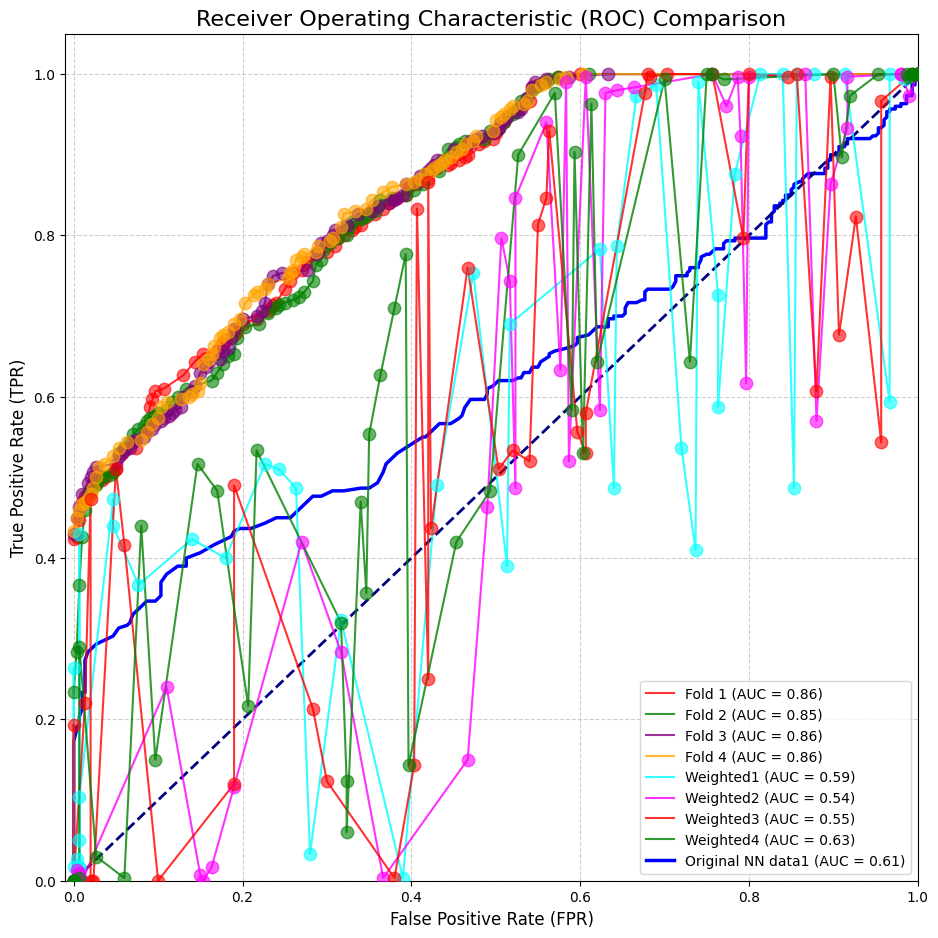

In [13]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [14]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.4167, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.4900, FPR: 0.0233]
Hard Voting -> Resulted in [TPR: 0.4733, FPR: 0.0100]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.5067, FPR: 0.0400]
Hard Voting -> Resulted in [TPR: 0.5133, FPR: 0.0367]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


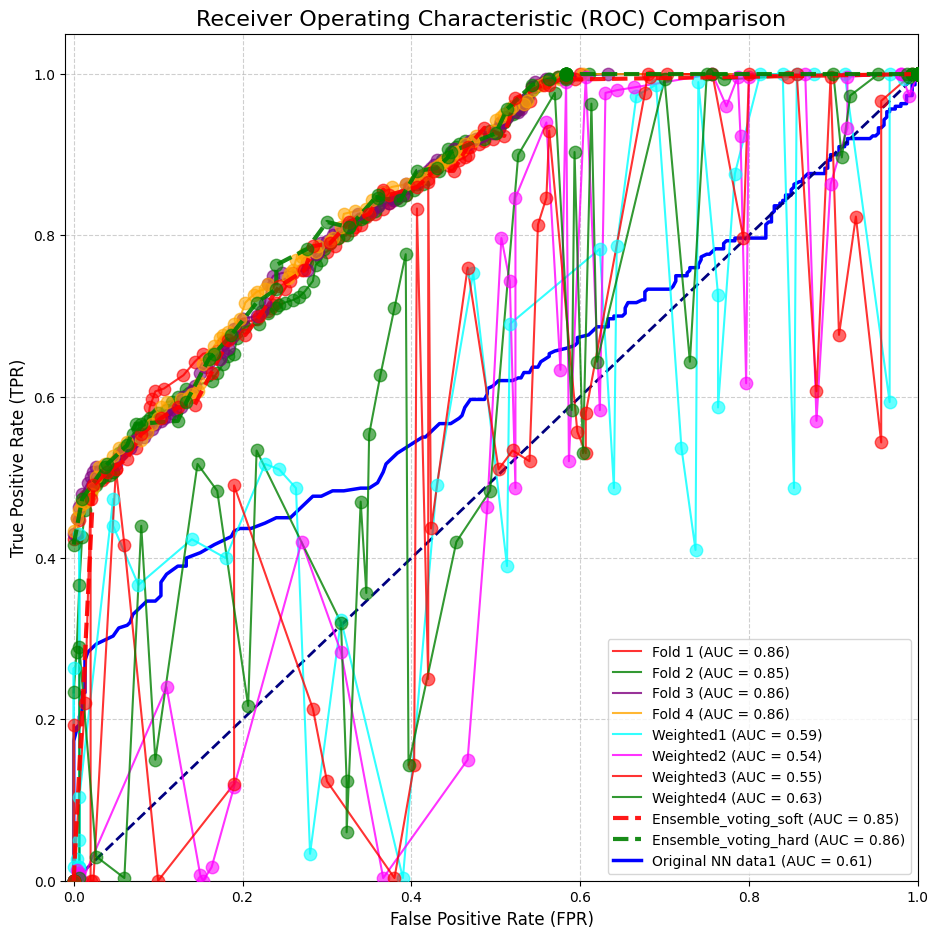

In [15]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)

## Check performances

## Check performance on test1 and test2

In [16]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs